# blimpy, ML, and Voyager 1
Created June 2020: Dominic LeDuc

**NOTE:** Some of these materials taken directly from the Breakthrough Listen `blimpy/voyager.ipynb` [demo](https://github.com/UCBerkeleySETI/blimpy/blob/master/examples/voyager.ipynb).

[Voyager 1](https://en.wikipedia.org/wiki/Voyager_1) is the most distant man-made object from Earth. Launched by NASA in 1977, it has travelled at fantastic speed (roughly 17,000 m/s), past the outer boundaries of our Solar System and into interstellar space (>12.5 billion miles from the Sun).

Remarkably, 39 years on, Voyager 1 is still sending telemetry data from the depths of interstellar space. This makes it a great systems test for the Breakthrough Listen signal processing pipeline.

In this tutorial, we load, read, and plot some Breakthrough Listen (BL) observations of Voyager 1. The data were taken using the [Robert C. Byrd Greenbank Telescope](https://science.nrao.edu/facilities/gbt) in West Virginia.

We will also develop a simple convolutional neural network/ConvNet/CNN that will be able to detect the carrier wave and sidebands from Voyager 1!

### About the data

We used the Greenbank X-band receiver (8.0-11.6 GHz) on December 30, 2015, to observe the known position of Voyager 1. The BL digital signal processing system saves digitized data in a 'raw' format, which we have converted into 'filterbank' format using our `gpuspec` code (see guppi2spectra.c in https://github.com/UCBerkeleySETI/gbt_seti/tree/master/src ). For *advanced users* who want to start from scratch, the specific command is:

```
time /gbt_seti/bin/gpuspec -i ./blc3_2bit_guppi_57386_VOYAGER1_0004.0000.raw \
    -B 2 -f 1032192 -t 15 -V -o /datax2/scratch/dprice/
```

For the purposes of this tutorial, we suggest that you download the 50 MB [Voyager1.single_coarse.fine_res.h5](http://blpd0.ssl.berkeley.edu/Voyager_data/Voyager1.single_coarse.fine_res.h5) consisting of a subset of frequencies (corresponding to a single coarse channel) in the blimpy github distribution.

#### Filterbank format 

The voyager data is stored in *filterbank format*, a simple binary file format that is detailed in the [SIGPROC user guide](http://sigproc.sourceforge.net/sigproc.pdf). For this tutorial, we've provided a simple Python class to load and interpret the filterbank file into a [numpy](http://www.numpy.org) array. 

## Installation and Setup
For this notebook to run properly, you'll need quite a few dependencies: Jupyter, numpy, scipy, blimpy, setigen, sklearn, and tensorflow. We've provided a `.yml` file to install these into a conda environment, assuming you have an Anaconda distribution installed. To do this, follow these steps:

1. Download https://github.com/DominicL3/turboSETI-ML/blob/master/alienhuntmode_env.yml either by clicking the link or by running

In [ ]:
! wget https://github.com/DominicL3/turboSETI-ML/blob/master/alienhuntmode_env.yml

2. In a terminal session, run `conda env create -f alienhuntmode_env.yml` (or whatever name you saved the file to). The first line of the `.yml` file sets the name of the environment. By default, it is "alienhuntmode," so change it to whatever you like! 

**IMPORTANT:** If you AREN'T on a Breakthrough Listen compute node and/or don't have a GPU, this step will probably fail (it tries to install tensorflow-gpu), and you'll have to install tensorflow manually. Training and predicting with neural networks will take considerablly longer.

3. Activate the conda environment by running `conda activate env_name`, where `env_name` is the name of the environment you set in the previous step.

If you haven't downloaded the data yet, we'll use `wget` to download the Voyager file.

In [ ]:
! wget http://blpd0.ssl.berkeley.edu/Voyager_data/Voyager1.single_coarse.fine_res.h5

### Imports

In [1]:
import numpy as np

# plot cool stuff
import matplotlib as mpl
import matplotlib.pyplot as plt

# the astronomy imports
import setigen as stg # generate artificial narrowband signals
from blimpy import Waterfall # read/manipulate filterbank files

# time things, miscellaneous system functions
from tqdm import tqdm, trange
from time import time
import os, sys, glob, copy

from sklearn.model_selection import train_test_split

In [2]:
# on blpc1, tells tensorflow to use ONLY GPU 3 (don't hog all the GPUs!)
# why GPU 3 when it's set to 0? Beats me
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# neural net imports
import tensorflow
tensorflow.compat.v1.disable_eager_execution() # eager execution gives me weird behavior

# different types of layers for constructing models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPooling2D

# model callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [3]:
# matplotlib settings
# you can change this if we have differing tastes in aesthetics
%matplotlib inline
params = {
    'savefig.dpi': 150,
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 16,
    'font.size': 12, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
}
mpl.rcParams.update(params)

# Part 1: Using blimpy
Disclaimer: Most of the material in this section is copied directly from the `voyager.ipynb` demo linked above.

Now, let's read the observation data using `Waterfall()`:

In [4]:
# bypass "No locks available" error, otherwise can't load in on blpc1
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
obs = Waterfall('Voyager1.single_coarse.fine_res.h5')

### Plotting the data

The `Waterfall()` class provides a `plot_spectrum()` function to plot the data:

extracting integration 0...


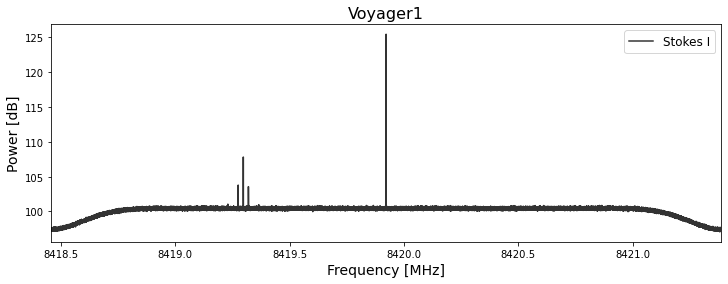

In [5]:
plt.figure(figsize=(12, 4))
obs.plot_spectrum(logged=True)

What we see here is the power spectral density (or simply "spectrum") of the data contained in the filterbank file.  The `logged=True` tells the plotting script to display the signal on a decibel scale, which makes it easier to see high dynamic range. 

Apparent in the plot are the edges of the digital filters, and a big spike in power in the centre. This is known as the 'DC bin', and is an artifact caused by the use of the Fast Fourier Transform (FFT) to create spectra. 

Voyager is a very narrowband signal, but we can still see it to the left of this plot. If we zoom in on where Voyager's telemetry is known to be, we see some very narrowband signals:

extracting integration 0...


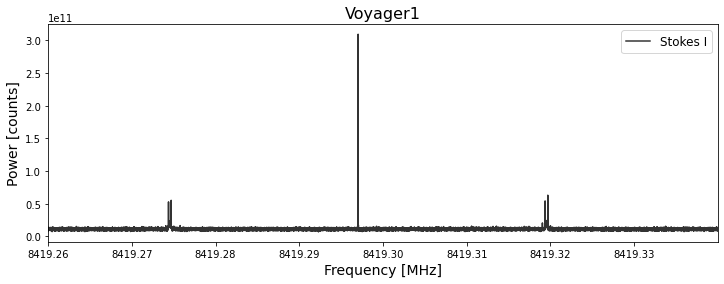

In [6]:
plt.figure(figsize=(12, 4))
obs.plot_spectrum(f_start=8419.26, f_stop=8419.34)

This is it: the telemetry signal from Voyager 1! What you see is the carrier (center) and two sidebands that carry the data. We can zoom in on these to see more features:

extracting integration 0...
extracting integration 0...
extracting integration 0...


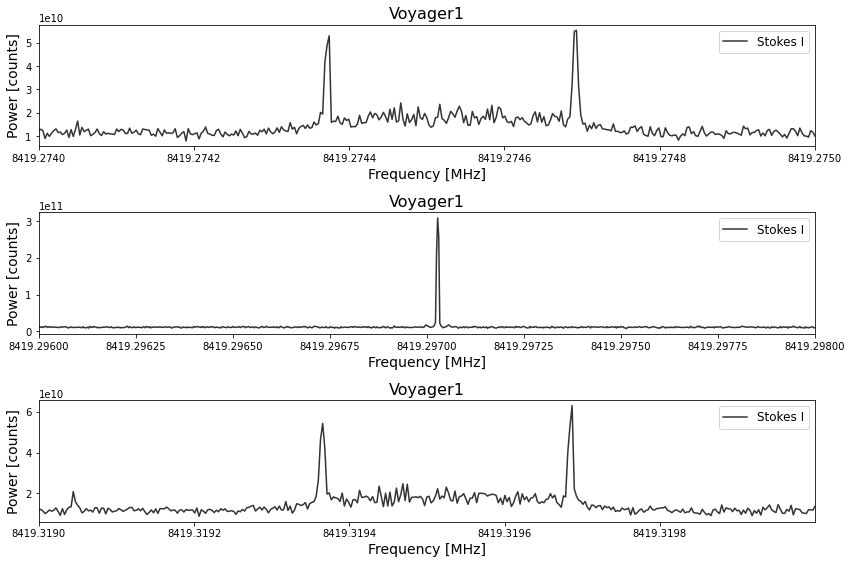

In [7]:
plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
obs.plot_spectrum(f_start=8419.274, f_stop=8419.275) # left sideband
plt.subplot(3,1,2)
obs.plot_spectrum(f_start=8419.296, f_stop=8419.298) # carrier
plt.subplot(3,1,3)
obs.plot_spectrum(f_start=8419.319, f_stop=8419.320) # right sideband
plt.tight_layout()

Because Voyager is not fixed on the surface of Earth, it has a relative motion with respect to the telescope, which causes its apparent frequency to drift. We can see this by plotting what's known as a 'Waterfall', or dynamic spectrum, which shows the spectrum as a function of time.

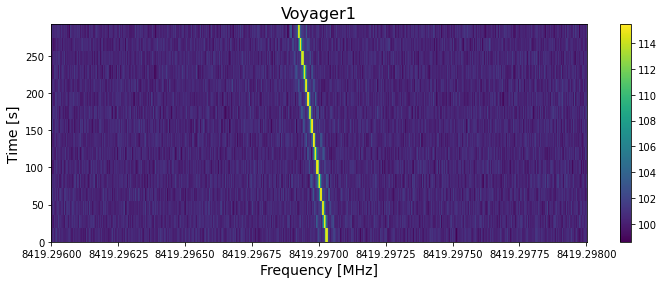

In [8]:
plt.figure(figsize=(12, 4))
obs.plot_waterfall(f_start=8419.296, f_stop=8419.298)

This is the carrier wave sent by Voyager 1! We can also check out the sidebands to the right of the carrier.

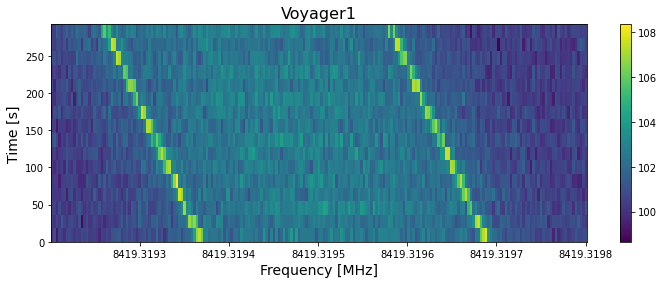

In [9]:
plt.figure(figsize=(12, 4))
obs.plot_waterfall(f_start=8419.3192, f_stop=8419.3198)

# Part 2: Using Neural Networks to Find Voyager 1

Now that we have an idea of what kinds of signals we want to predict, let's get cracking on the machine learning! As you may know, one of the ways to detect these signals is to teach a model how to do *binary classification*: given an array, our trained model should output a probability whether or not there's a signal present.

# Generate dataset using setigen

Since each block in the Voyager file has 16 time samples and 1024 frequency channels, each block will have shape (16, 1024). 

Let's create an artificial dataset! The backgrounds for our injected signals will start off as 1000 16x1024 arrays of simple Gaussian random noise. You can change `num_samples`—usually there needs to be a *lot* more than 1000 samples in a training set for a neural network (maybe like a couple hundred thousand)—but I kept the training set small for demonstration purposes.

In [10]:
frame = stg.Frame(waterfall=obs)

In [11]:
# define shape of neural network input
num_samples = 1000
fchans = 1024
tchans = 16
training_set_shape = (num_samples, tchans, fchans)

training_data = np.random.normal(loc=np.mean(obs.data), scale=np.std(obs.data), 
                                size=training_set_shape)

This next part is a bit of a doozy, but it's not too bad. All we're doing is randomly generating some parameters to simulate the narrowband signals. `setigen` allows us to specify where we'd like the signal to begin, the drift rate (slope in units of Hz/s), signal-to-noise ratio (SNR), width of the signal, and its frequency profile.

This next part basically iterates through all our previously generated training data and *randomly samples* values for each of the parameters we specified above. For ease, every sample comes from a uniform distribution.

After that, we copy a version of the data WITHOUT a signal in it and give it a label of 0, hoping that the CNN will learn to assign values of 0 to arrays that don't have any signal in them. Then, we inject a signal into the frame and append that into our training data as well, assigning it a label of 1.

In [12]:
training_frames, labels = [], []

# generate dataset, taken from setigen docs (advanced topics)
for data in tqdm(training_data):
    frame = stg.Frame(data=data, fchans=fchans, tchans=tchans, df=frame.df, dt=frame.dt)
    
    # start index in the middle 50% of the image (don't want signal to trail too far off)
    start_index = np.random.randint(0.25 * fchans, 0.75 * fchans)
    
    # sample drift rate uniformly between -5 and 5 Hz/s
    drift_rate = np.random.uniform(-5, 5)
    
    # sample SNR and frequency profile randomly
    random_SNR = np.random.uniform(8, 20) # 8 + np.random.lognormal(mean=1.0, sigma=1.0)
    width = np.random.uniform(10, 40)
    f_profile_type = np.random.choice(['box', 'gaussian', 'lorentzian', 'voigt'])
    
    # add metadata to each frame for bookkeeping purposes
    signal_props = {
        'start_index': start_index,
        'drift_rate': drift_rate,
        'snr': random_SNR,
        'width': width,
        'f_profile_type': f_profile_type
    }
    frame.add_metadata(signal_props)
    
    # add blank observation with label 0 to training set
    training_frames.append(copy.deepcopy(frame))
    labels.append(0)

    # add signal to background
    signal = frame.add_constant_signal(f_start=frame.get_frequency(start_index),
                                   drift_rate=drift_rate,
                                   level=frame.get_intensity(snr=random_SNR),
                                   width=width,
                                   f_profile_type=f_profile_type)
    
    
    # append frame with signal to training set
    training_frames.append(copy.deepcopy(frame))
    labels.append(1)
    
training_frames = np.array(training_frames)
labels = np.array(labels)

100%|██████████| 1000/1000 [00:03<00:00, 300.95it/s]


## Viewing simulated data
After we've created the dataset, we should take a look at a few samples to make sure that everything is peachy.

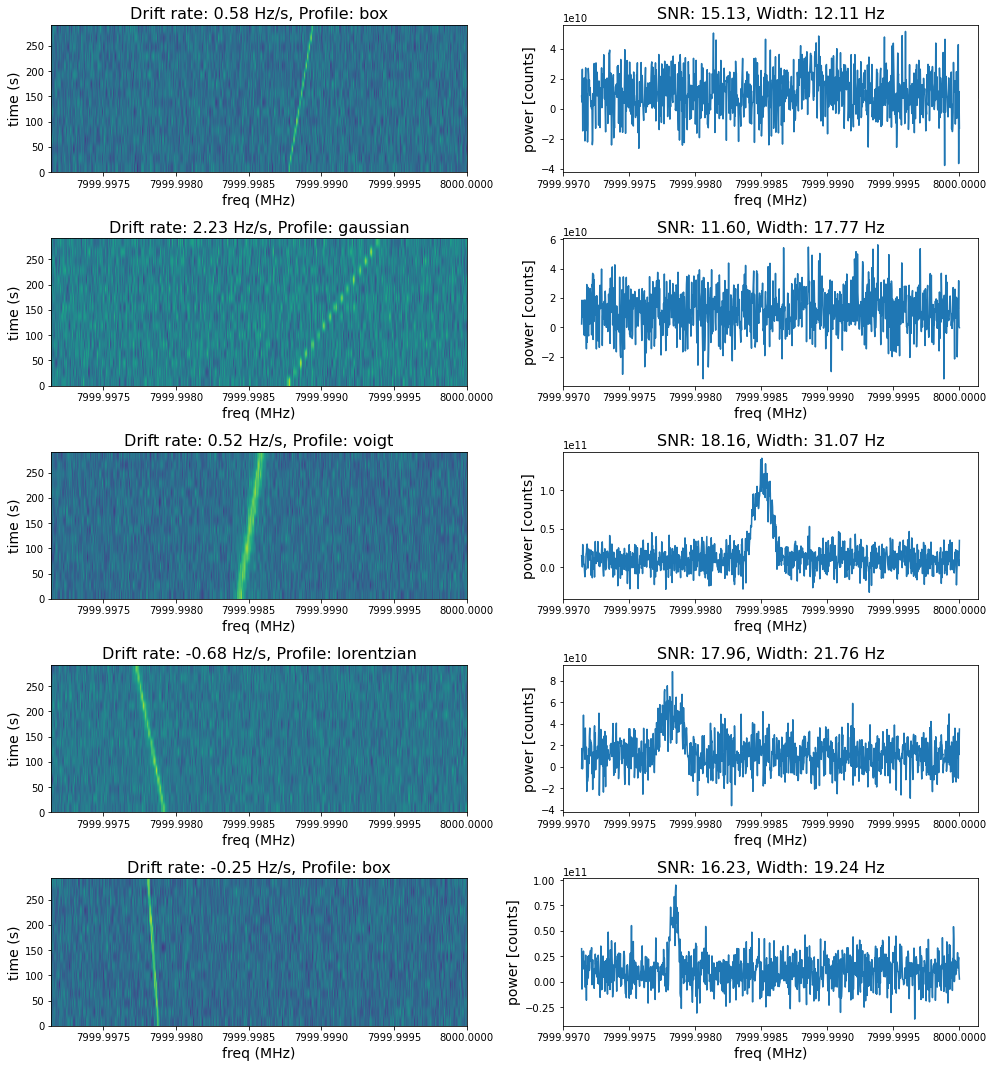

In [14]:
num_to_plot = 5
fig_height = num_to_plot * 3

# start np.arange() at 0 for RFI, 1 for simulated signals
# since labels alternates between 0 and 1
label_inds = np.arange(1, len(training_frames), 2)
rand_idx = np.random.choice(label_inds, size=num_to_plot)

fig_setigen, ax_setigen = plt.subplots(nrows=num_to_plot, ncols=2, figsize=(14, fig_height))
for frame, ax in zip(training_frames[rand_idx], ax_setigen):
    data = frame.get_data()
    signal = np.mean(data, axis=0) # compute 1D signal
    
    snr = frame.metadata['snr']
    width = frame.metadata['width']
    drift_rate = frame.metadata['drift_rate']
    f_profile_type = frame.metadata['f_profile_type']
    
    # plot 2D spectrogram of narrowband signal
    extent = [frame.get_frequency(0)/1e6, frame.fmax/1e6, 0, frame.tchans*frame.dt]
    ax[0].imshow(data, extent=extent, origin='lower', aspect='auto')
    ax[0].set(ylabel='time (s)', xlabel='freq (MHz)', title=f"Drift rate: {drift_rate:.2f} Hz/s, Profile: {f_profile_type}")
    
    # plot 1D spectrum
    ax[1].plot((np.arange(len(signal)) * frame.df + frame.get_frequency(0))/1e6, signal)
    ax[1].set(xlabel='freq (MHz)', ylabel='power [counts]', title=f"SNR: {snr:.2f}, Width: {width:.2f} Hz")
      
fig_setigen.tight_layout()

## Preprocessing setigen frames for model training
Now that the dataset has been created, we need to extract the data from each Frame to train the netwoork.

In [15]:
# get frequency-time data from each Setigen frames
ftdata = np.array([frame.get_data() for frame in training_frames])

Finally, before we feed the inputs for training, we need to preprocess the arrays by bringing them to zero mean and unit standard deviation. **I cannot stress to you how important this is.** 

It's *ridiculous* how long I spent miserably debugging my models when it was in fact an error in my data preprocessing.

In [16]:
def scale_data(ftdata):
    """Subtract each frequency channel in 3D array by its median and
    divide each array by its global standard deviation."""

    # pre-allocate array for speed
    scaled_ftdata = np.zeros(ftdata.shape)
    
    for i, arr in enumerate(tqdm(ftdata)):
        medians = np.median(arr, axis=1).reshape(-1, 1)
        stddev = np.std(arr) # add small number to avoid divide by zero

        scaled_ftdata[i, :, :] = (arr - medians) / stddev
    return scaled_ftdata

In [17]:
# normalize ftdata before inputting to model
scaled_ftdata = scale_data(ftdata)

100%|██████████| 2000/2000 [00:01<00:00, 1596.86it/s]


After our data has been preprocessed, we need to split our original training data. Some terms:

- training set: data that model sees and gets trained on
- validation set: separate set of held-out data. Often used to tune model hyperparameters, so the model tends to become biased towards improving validation performance
- test set: data that is held out until after model is done training, the *final* test after training and valildation has been completed

In our case, our artificial dataset can be separated into training and validation sets, while the test set is the Voyager file we would like to predict on in the end.

In [18]:
# split data into training and validation sets
start_time = time()
print('Splitting data into training and validation sets...')
train_ftdata, val_ftdata, train_labels, val_labels = train_test_split(scaled_ftdata, labels, train_size=0.5)
print(f"Split data in {time() - start_time:.2f} seconds!\n")

Splitting data into training and validation sets...
Split data in 0.13 seconds!



In our final step of preprocessing, we need to add an extra dimension. This is because Keras expects the input array to have a dimension of "channels". For an RGB image, this would mean the input arrays would have shape (16, 1024, 3). Since we only have one channel to deal with, our array shapes will be (16, 1024, 1).

In [19]:
# add channel dimension to input
train_ftdata = train_ftdata[..., None]
val_ftdata = val_ftdata[..., None]

print(train_ftdata.shape)

(1000, 16, 1024, 1)


## Creating the neural network

This is the moment you've been waiting for: designing the neural network. Since the task at hand is relatively simple—basically detecting whether a diagonal line is present in an image—we don't need to go overboard with 100+ layers like some state-of-the-art methods. We'll design a super simple model that'll do the trick just fine.

Play around with this function! See how changing the number of convolutional layers, number of filters, or number of Dense units changes model convergence, training speed, etc.

In [20]:
def construct_conv2d(img_shape=(16, 1024), num_conv_layers=2, num_filters=32, 
                     n_dense1=128, n_dense2=64):
    """
    Parameters:
    ----------
    num_conv_layers : int
        Number of convolutional layers to implement (MAX 4 due to pooling layers,
        otherwise Keras will throw an error)
    num_filters : int
        Number of filters in first convolutional layer, doubles after each convolutional block.  
    n_dense1 : int
        Number of neurons in first hidden layer
    n_dense2 : int
        Number of neurons in second hidden layer

    Returns
    -------
    cnn_2d : Keras model
        Model to be used on frequency-time data
    """

    # define input layer with the given input image shape
    input_layer = Input([*img_shape, 1])
    
    # create num_filters convolution filters, each of size 3x3
    cnn_2d = Conv2D(num_filters, (3, 3), padding='same')(input_layer)
    cnn_2d = BatchNormalization()(cnn_2d) # standardize all inputs to activation function
    cnn_2d = Activation('relu')(cnn_2d) # pass through ReLU activation function
    cnn_2d = MaxPooling2D(pool_size=(2, 2))(cnn_2d) # max pool to reduce dimensionality by half

    # repeat and double the filter size for each convolutional block to make this DEEP
    for layer_number in range(2, num_conv_layers + 1):
        num_filters *= 2
        cnn_2d = Conv2D(num_filters, (3, 3), padding='same')(cnn_2d)
        cnn_2d = BatchNormalization()(cnn_2d)
        cnn_2d = Activation('relu')(cnn_2d)
        cnn_2d = MaxPooling2D(pool_size=(2, 2))(cnn_2d)

    # max pool all feature maps
    cnn_2d = GlobalMaxPooling2D()(cnn_2d)
    
    # run through two fully connected layers
    # add Dropout (cheap and easy way to mitigate overfitting)
    fc_layers = Dense(n_dense1, activation='relu')(cnn_2d)
    fc_layers = Dropout(0.25)(fc_layers)

    fc_layers = Dense(n_dense2, activation='relu')(fc_layers)
    fc_layers = Dropout(0.25)(fc_layers)
    
    # final prediction layer, sigmoid activation squashes real-valued inputs to range (0, 1)
    pred_layer = Dense(1, activation='sigmoid')(fc_layers)
    
    model = Model(inputs=input_layer, outputs=pred_layer)

    return model

In [21]:
# build model
voyager_model = construct_conv2d(num_conv_layers=2, n_dense1=64, n_dense2=32)

tensorflow      WARNING  From /home/dleduc/yes/envs/alienhuntmode/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1635: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


We can take a peek at the architecture of our model below:

In [22]:
voyager_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 1024, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 1024, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 1024, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 16, 1024, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 512, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 512, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 512, 64)        256   

Another cool way to visualize neural networks is via [Netron](https://lutzroeder.github.io/netron/https://lutzroeder.github.io/netron/), where we can just upload a saved model to the browser and get a nice illustration of our model.

Now we must compile the model and tell it what **loss function** to use. The loss function is the function the neural network tries to optimize. There are many optimizers you can choose from to carry out this optimization, but `Adam` is a good default choice.

In [24]:
# optimize using Adam and with binary_crossentropy loss
voyager_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
# save model with lowest validation loss
saved_model_name = 'best_model.h5'
loss_callback = ModelCheckpoint(saved_model_name, monitor='val_loss', verbose=1, save_best_only=True)

# cut learning rate in half if validation loss doesn't improve in 5 epochs
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# stop training if validation loss doesn't improve after 10 epochs
early_stop_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [26]:
start_time = time() # training time
voyager_model.fit(x=train_ftdata, y=train_labels, validation_data=(val_ftdata, val_labels),
                  batch_size=32, epochs=32, callbacks=[loss_callback, reduce_lr_callback, early_stop_callback])
print(f"Training finished in {(time() - start_time) / 60:.4f} minutes")

Train on 1000 samples, validate on 1000 samples
Epoch 1/32
 992/1000 [============================>.] - ETA: 0s - loss: 0.8321 - accuracy: 0.6502
Epoch 00001: val_loss improved from inf to 0.51379, saving model to best_model.h5
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.8278 - accuracy: 0.6520 - val_loss: 0.5138 - val_accuracy: 0.9950
Epoch 2/32
 992/1000 [============================>.] - ETA: 0s - loss: 0.1591 - accuracy: 0.9476
Epoch 00002: val_loss improved from 0.51379 to 0.22159, saving model to best_model.h5
1000/1000 [==============================] - 1s 895us/sample - loss: 0.1590 - accuracy: 0.9480 - val_loss: 0.2216 - val_accuracy: 0.9960
Epoch 3/32
 992/1000 [============================>.] - ETA: 0s - loss: 0.0500 - accuracy: 0.9919
Epoch 00003: val_loss improved from 0.22159 to 0.10575, saving model to best_model.h5
1000/1000 [==============================] - 1s 882us/sample - loss: 0.0497 - accuracy: 0.9920 - val_loss: 0.1058 - val_accuracy: 0.

Hopefully, if the model didn't get stuck in a truly bad local minimum, training and validation accuracy should be close to 100%, because the dataset is small and not too challenging.

# Test model predictions

Finally, we can test the model by running it on the Voyager file and see if it finds the carrier and sidebands.

However, we must first preprocess the file. Since the Voyager data comes in one large array of size (16, 1048576), we need to split it up so that each individual array has 1024 frequency channels, since the model was originally trained on images of size (16, 1024).

The function below helps us split a long array into chunks, each with `bins_per_array` frequency bins. If `bins_per_array` doesn't divide evenly into the number of original frequency bins, the last array will be a copy of the last `bins_per_array` frequency bins so we don't lose any information. 

**Note**: this code is not terribly efficient, but it's good enough for demo purposes. Use Numba or np.split for something faster.

In [28]:
def split(array, bins_per_array):
    """
    Splits long 2D array into 3D array of multiple 2D arrays,
    such that each has bins_per_array time bins. Drops the
    last chunk if it has fewer than bins_per_array bins.

    Returns:
        split_array : numpy.ndarray
            Array after splitting.
    """

    total_bins = array.shape[1]

    # pre-allocate split array with extra final element if necessary
    # each individual chunk should have shape (num_rows_in_array, bins_per_array)
    split_array = np.zeros((int(np.ceil(total_bins/bins_per_array)), array.shape[0], bins_per_array),
                          dtype=array.dtype)
    
    # set each individual chunk in split_array to some slice in original array
    for i in trange(len(split_array)):
        split_array[i:, :] = array[:, i * bins_per_array:(i+1) * bins_per_array]

    if total_bins % bins_per_array != 0: # fix when unevenly split
        # last array currently only filled partially
        # set last array in split_array to larger chunk from the end
        split_array[-1] = array[:, -bins_per_array:]

    return split_array

In [29]:
# split voyager data from (16, 18750000) to shape (18750000/1024, 16, 1024)
voyager_ftdata = split(obs.data[:, 0], 1024)
print(f"Original shape of Voyager file: {obs.data[:, 0].shape}")
print(f"Shape of split array: {voyager_ftdata.shape}")

100%|██████████| 1024/1024 [00:07<00:00, 132.56it/s]

Original shape of Voyager file: (16, 1048576)
Shape of split array: (1024, 16, 1024)


Now we need to preprocess our Voyager test data by performing the same exact preprocessing steps as we did on the training and validation data. Like I said before, this part is **super** important; I've spent a long long time frustrated over my neural network performing poorly when it was really my inconsistent preprocessing that killed me.

Therefore, we must do our normalization the exact same way and subsequently append an extra dimension to represent the number of channels for Keras.

In [30]:
# scale Voyager data so that for every individual chunk of the 1024 split pieces 
# each spectrum (row) has 0 median and chunk has stddev of 1
scaled_voyager_ftdata = scale_data(voyager_ftdata)

100%|██████████| 1024/1024 [00:00<00:00, 1364.08it/s]


We can verify that each row in individual array has median 0 and the entire array has standard deviation of 1 as we expect. Bear in mind that due to floating point precision, most of the medians will not be exactly 0 but some small number ($\sim 10^{-7}$), and the standard deviation will be very close to, but not exactly 1.

In [35]:
# pick a random array in scaled_voyager_ftdata
random_chunk = scaled_voyager_ftdata[np.random.randint(len(scaled_voyager_ftdata))]

print(f"Medians: {np.median(random_chunk, axis=1)}")
print(f"Global stddev : {np.std(random_chunk)}")

Medians: [-4.41330485e-07  4.41301381e-07  0.00000000e+00  0.00000000e+00
  0.00000000e+00  4.41301381e-07  0.00000000e+00 -4.41297743e-07
 -4.41301381e-07  0.00000000e+00  4.41330485e-07 -4.41297743e-07
  0.00000000e+00  0.00000000e+00  4.41301381e-07 -4.41330485e-07]
Global stddev : 0.9998935165857274


In [36]:
# append channel dimension
scaled_voyager_ftdata = scaled_voyager_ftdata[..., None]
print(scaled_voyager_ftdata.shape)

(1024, 16, 1024, 1)


Onward to the prediction step! We can finally run the predictions through our model. Because the last layer of our neural network passes through a sigmoid activation function, these predictions will be in the range (0, 1) and can be interpreted (loosely) as the probability of having a signal in an array.

We can set a threshold (usually 0.5) of what probability above which the array will be labeled a predicted signal. Lower thresholds mean you need a lower predicted probability to be considered a signal, and vice-versa.

In [37]:
pred_voyager = voyager_model.predict(scaled_voyager_ftdata, verbose=1)

# get indices for arrays that were deemed true signals (arrays with probabilities above threshold)
threshold = 0.5
voted_signal_inds = np.where(pred_voyager > threshold)[0] 

print(f"\nNumber of signals: {len(voted_signal_inds)}")

1024/1024 [==============================] - 0s 429us/sample

Number of signals: 12


## Plotting model predictions on test set
This is the final test. Now that we've gotten prediction probabilities for every slice of the Voyager file, and we know the indices of arrays that were predicted to have signals in them, we can plot those arrays and verify if our model was able to actually detect the Voyager carrier wave and sidebands that we set out to find.

Firstly, we need to get the frequency bounds for every slice of the Voyager file so that we can cross-check with the blimpy plots above whether the frequencies of our predicted signals line up with the known frequencies of the carrier and sidebands. To do this, we can split the array of frequencies using our previously defined splitting function.

In [38]:
voyager_freqs = obs.container.populate_freqs() # get frequencies of observation
voyager_freqs = voyager_freqs.reshape(1, -1) # split() expects a 2D array, not 1D

# split up frequencies
voyager_freqs_split = split(voyager_freqs, 1024)
print(f"Shape of voyager_freqs_split: {voyager_freqs_split.shape}")

100%|██████████| 1024/1024 [00:00<00:00, 3102.56it/s]

Shape of voyager_freqs_split: (1024, 1, 1024)


In [39]:
# also compute total observation time for plotting (seconds)
t_obs = obs.header['tsamp'] * obs.n_ints_in_file

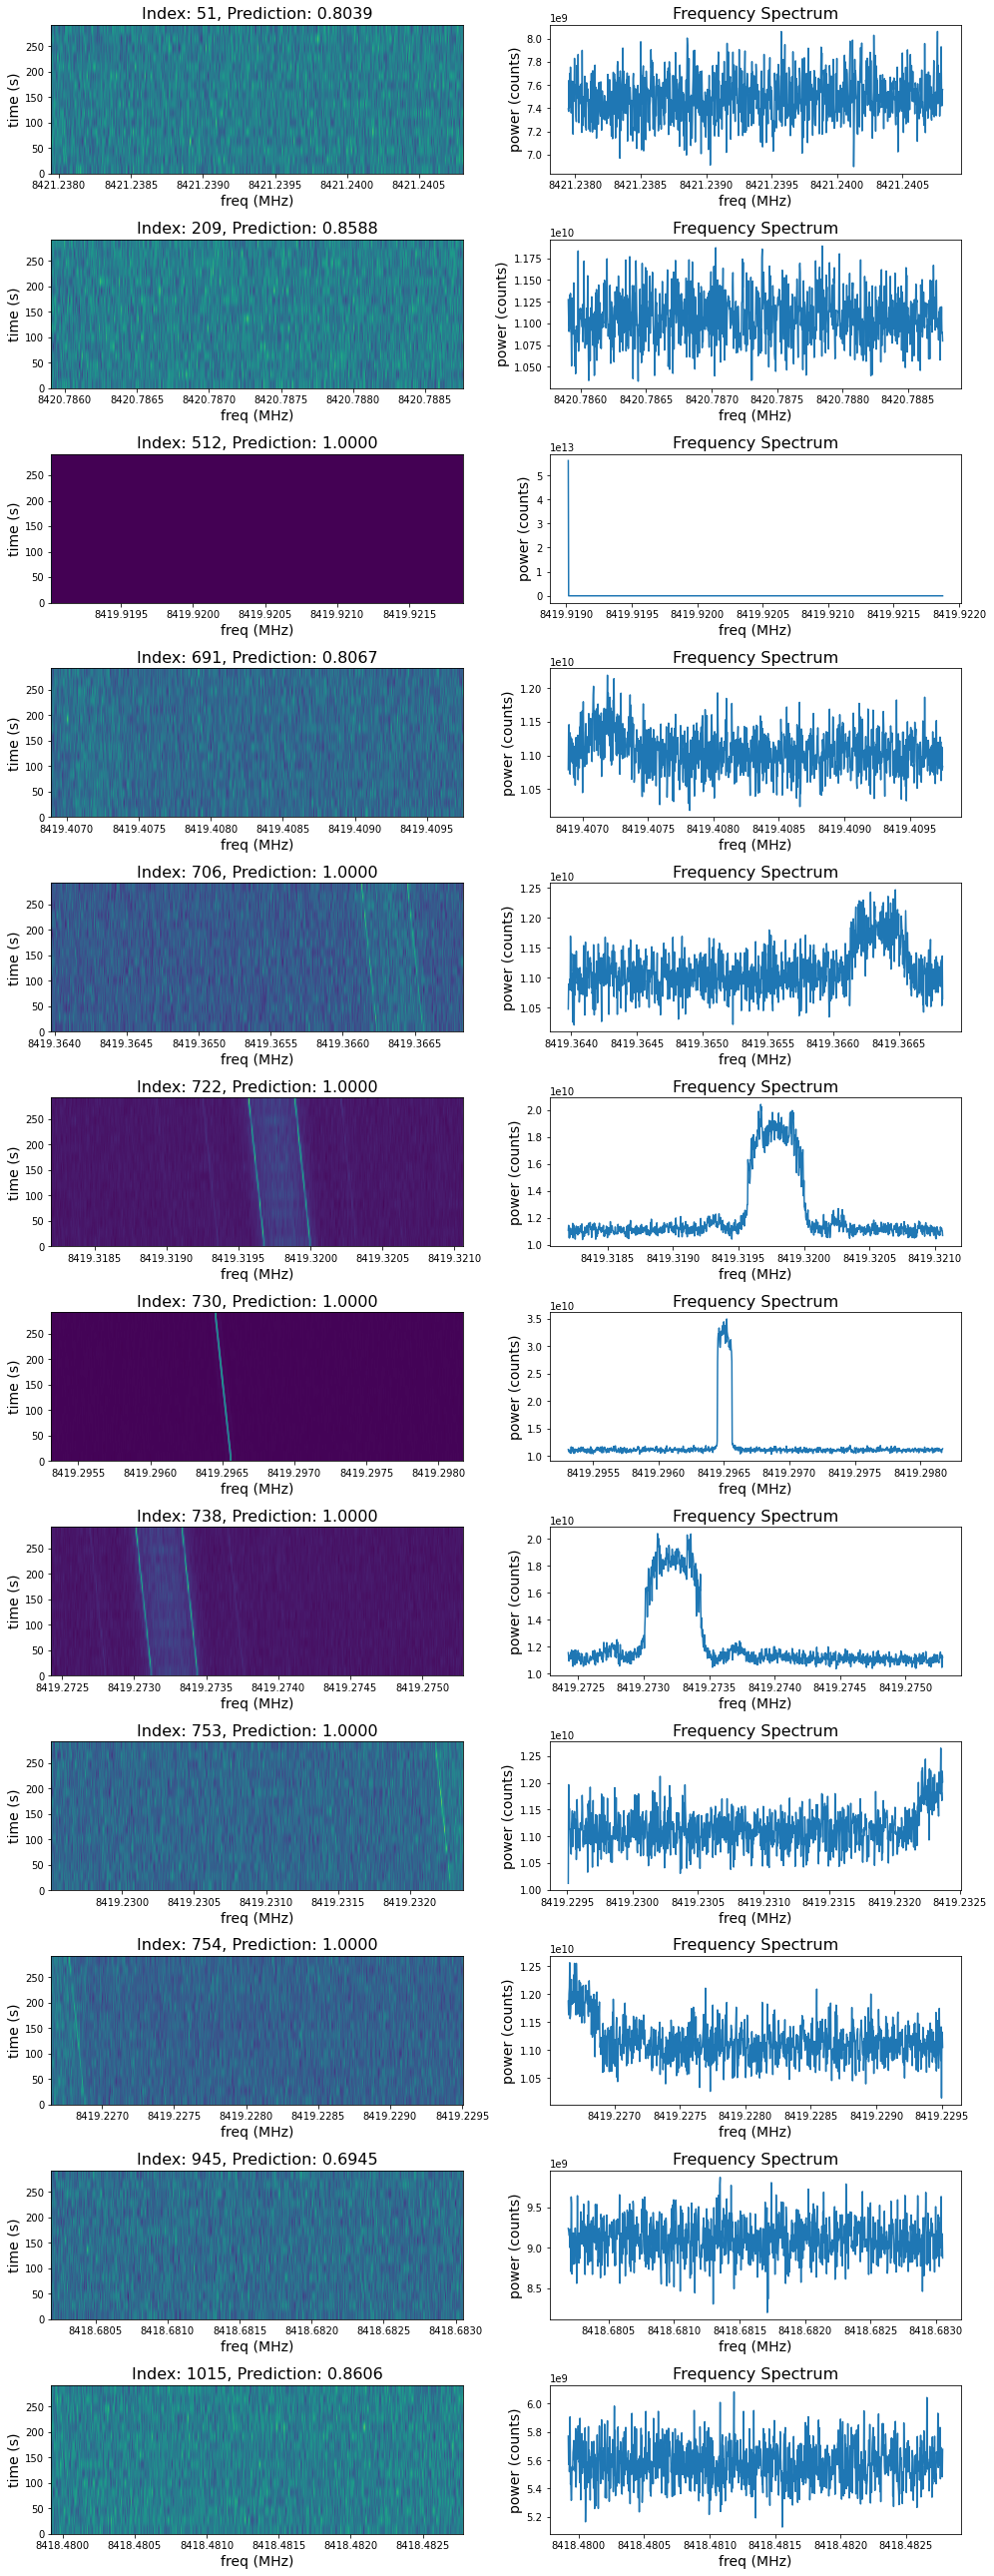

In [40]:
# plot the model's predicted signals
num_to_plot = 20 # set max number of predicted signals to plot
fig_height = np.min([num_to_plot, len(voted_signal_inds)]) * 3

fig_narrowband, ax_narrowband = plt.subplots(nrows=np.min([num_to_plot, len(voted_signal_inds)]), 
                                             ncols=2, figsize=(14, fig_height))

for signal_index, ax in zip(voted_signal_inds, ax_narrowband):
    # extract random array with corresponding freqs and prediction probability
    signal = voyager_ftdata[signal_index]
    freq = voyager_freqs_split[signal_index, 0] # remember that voyager_freqs_split is 3D
    prob = pred_voyager[signal_index, 0]
    
    # plot spectrogram
    # signal is reversed because frequencies are reversed in original data
    ax[0].imshow(signal[::-1], aspect='auto', origin='lower', 
                 extent=[np.min(freq), np.max(freq), 0, t_obs])
    ax[0].set(xlabel='freq (MHz)', ylabel='time (s)', 
              title=f"Index: {signal_index}, Prediction: {prob:.4f}")
     
    # plot spectrum
    # frequencies are reversed in original data, must flip them
    spectrum = np.mean(signal, axis=0)
    ax[1].plot(freq[::-1], spectrum)
    ax[1].set(xlabel='freq (MHz)', ylabel='power (counts)', title='Frequency Spectrum')

fig_narrowband.tight_layout()

We can see that the model is succesfully able to pick out the carrier and the sidebands! What's more, it's also able to pick out the weaker sidebands as well.

Of course, you may be wondering why there are many arrays that contain nothing. The problem with neural networks is that they're considered a "black box," so it's more difficult to debug why something went wrong here than for other machine learning methods like Decision Trees. Unfortunately, I can't tell you what exactly is in these noisy arrays that trips up the model.

# Final Thoughts

If you've made it this far, congratulations! We've just used a simple convolutional neural network to detect the Voyager signals. Doesn't seem too bad, right? There are some things we need to consider, however:

- The Voyager test data is *super* clean. Like, really clean. There are no instances of radio frequency interference (RFI) at all, except if you want to count the DC bin artifact. In other situations, you will definitely have to account for RFI, and the model would probably predict that RFI are true signals, since it looks a lot like the real thing. If you want to account for RFI...

- Using Gaussian random noise as the simulated background is probably not the best thing to do, unless you are super confident that your data is not corrupted at all. Otherwise, your model will trip up over every single thing that **isn't** Gaussian noise. If you can, try to use actual telescope observations as your backgrounds, but make sure that there are no real signals in them!